In [1]:
import numpy as np
import os
import PIL
import tensorflow as tf
import random
from tensorflow.python.framework.ops import disable_eager_execution
from tensorflow.python.framework.ops import enable_eager_execution
import cv2

disable_eager_execution()
#enable_eager_execution()

In [2]:
import matplotlib.pyplot as plt
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import mixed_precision

In [3]:
from __future__ import print_function
import argparse
from tensorflow.keras.layers import Input
import scipy.misc

from configs import bcolors
from utils import *
import tensorflow_model_optimization as tfmot


from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.vgg19 import VGG19

# Load Images with Same Label (4?)

In [4]:
with open('ImageNetLabels.txt') as f:
    classes = f.readlines()
# you may also want to remove whitespace characters like `\n` at the end of each line
classes = [x.strip() for x in classes] 

In [5]:
target_images = []
with open('test_images.npy', 'rb') as f:
    target_images.append(np.load(f, encoding='bytes',allow_pickle=True))
    target_images.append(np.load(f, encoding='bytes',allow_pickle=True))
    target_images.append(np.load(f, encoding='bytes',allow_pickle=True))
    target_images.append(np.load(f, encoding='bytes',allow_pickle=True))

# Build Model

In [6]:
# input image dimensions
img_rows, img_cols = 224 ,224
input_shape = (img_rows, img_cols, 3)
model_ = VGG16(input_shape=input_shape)
# q_aware stands for for quantization aware.
q_model = tfmot.quantization.keras.quantize_model(model_)
model = VGG16(input_tensor = q_model.get_layer('input_1').input)

# Display Image

In [7]:
gen_img = target_images[1]
pil_img = tf.keras.preprocessing.image.array_to_img(gen_img[0,:,:,:])

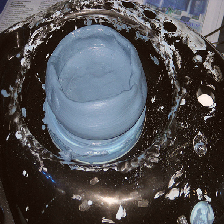

In [8]:
from IPython.display import Image
display(pil_img)

In [9]:
pred1, pred2 = model.predict(gen_img), q_model.predict(gen_img)
label1, label2 = np.argmax(pred1[0]), np.argmax(pred2[0])

Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.


In [10]:
tf.keras.applications.resnet.decode_predictions(pred1, top=5)[0]

[('n03992509', "potter's_wheel", 0.5384481),
 ('n04259630', 'sombrero', 0.18596433),
 ('n03786901', 'mortar', 0.042235207),
 ('n03970156', 'plunger', 0.029749354),
 ('n04447861', 'toilet_seat', 0.022260444)]

In [11]:
tf.keras.applications.resnet.decode_predictions(pred2, top=5)[0]

[('n03992509', "potter's_wheel", 0.003064962),
 ('n02791270', 'barbershop', 0.0022047707),
 ('n03929855', 'pickelhaube', 0.0020067284),
 ('n07754684', 'jackfruit', 0.0019144817),
 ('n02098286', 'West_Highland_white_terrier', 0.0019144817)]

# Generate adverserial example

In [12]:
weight_diff = pow(10, 11)
orig_label = label1
grad_iterations = 20
transformation = 'light'
step = 10

In [13]:
input_tensor = q_model.get_layer('input_1').input
loss1 =  K.mean(model.get_layer('predictions').output[..., orig_label])
loss2 =  K.mean(q_model.get_layer('quant_predictions').output[..., orig_label])
final_loss = K.mean(loss1 - weight_diff*loss2)
grads = normalize(K.gradients(final_loss, input_tensor)[0])
iterate = K.function([input_tensor], [grads])

#grads = tf.gradients(loss1, input_tensor_1)[0] - weight_diff*tf.gradients(loss2, input_tensor_2)[0]
#iterate = K.function([input_tensor_1,input_tensor_2], [grads])

In [14]:
orig_img = gen_img.copy()
for iters in range(0,grad_iterations):
    grads_value = iterate([gen_img])[0]
    if transformation == 'light':
        grads_value = constraint_light(grads_value)  # constraint the gradients value
    elif transformation == 'occl':
        grads_value = constraint_occl(grads_value, start_point,occlusion_size)  # constraint the gradients value
    elif transformation == 'blackout':
        grads_value = constraint_black(grads_value)  # constraint the gradients value

    gen_img += grads_value * step
    pred1, pred2= model.predict(gen_img), q_model.predict(gen_img)
    label1, label2 = np.argmax(pred1[0]), np.argmax(pred2[0])
    if not label1 == label2:
        gen_img_deprocessed = deprocess_image(gen_img)
        orig_img_deprocessed = deprocess_image(orig_img)
        break

In [15]:
pred1, pred2= model.predict(gen_img), q_model.predict(gen_img)

In [16]:
tf.keras.applications.resnet.decode_predictions(pred1, top=5)[0]

[('n03065424', 'coil', 0.7993795),
 ('n04523525', 'vault', 0.14318997),
 ('n04447861', 'toilet_seat', 0.032885578),
 ('n04286575', 'spotlight', 0.0076582944),
 ('n02808440', 'bathtub', 0.0037040089)]

In [17]:
tf.keras.applications.resnet.decode_predictions(pred2, top=5)[0]

[('n03992509', "potter's_wheel", 0.003064962),
 ('n02791270', 'barbershop', 0.0022047707),
 ('n03929855', 'pickelhaube', 0.0020067284),
 ('n07754684', 'jackfruit', 0.0019144817),
 ('n02098286', 'West_Highland_white_terrier', 0.0019144817)]

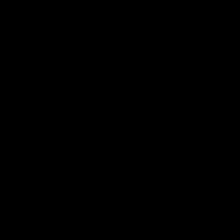

In [18]:
display(tf.keras.preprocessing.image.array_to_img(gen_img_deprocessed))

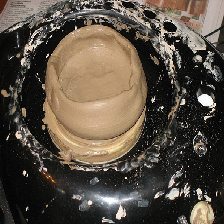

In [19]:
display(tf.keras.preprocessing.image.array_to_img(orig_img_deprocessed))

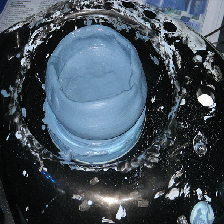

In [20]:
display(tf.keras.preprocessing.image.array_to_img(gen_img[0,:,:,:]))

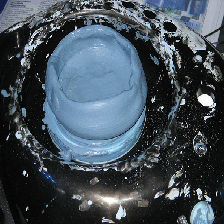

In [21]:
display(tf.keras.preprocessing.image.array_to_img(orig_img[0,:,:,:]))

In [22]:
orig_img[0,:,:,:]

array([[[ 18.,  27.,  64.],
        [ 16.,  28.,  68.],
        [ 22.,  31.,  74.],
        ...,
        [160., 165., 186.],
        [143., 150., 167.],
        [156., 163., 182.]],

       [[ 14.,  32.,  69.],
        [ 19.,  32.,  64.],
        [ 18.,  32.,  68.],
        ...,
        [161., 168., 185.],
        [151., 160., 173.],
        [161., 170., 184.]],

       [[ 16.,  31.,  64.],
        [ 12.,  28.,  65.],
        [ 13.,  27.,  63.],
        ...,
        [155., 164., 178.],
        [167., 170., 185.],
        [162., 167., 182.]],

       ...,

       [[  5.,   5.,   5.],
        [  5.,   5.,   5.],
        [ 10.,  10.,  10.],
        ...,
        [ 11.,  15.,  16.],
        [  9.,  14.,  15.],
        [ 12.,  17.,  18.]],

       [[ 29.,  29.,  29.],
        [  0.,   0.,   0.],
        [  9.,   9.,   9.],
        ...,
        [ 13.,  17.,  18.],
        [ 14.,  19.,  18.],
        [ 10.,  15.,  14.]],

       [[ 10.,  10.,  10.],
        [  7.,   7.,   7.],
        [  9.,  

In [23]:
gen_img[0,:,:,:]

array([[[-492.20816, -483.20813, -446.20813],
        [-494.20816, -482.20813, -442.20813],
        [-488.20816, -479.20813, -436.20813],
        ...,
        [-350.20813, -345.20813, -324.20813],
        [-367.20813, -360.20813, -343.20813],
        [-354.20813, -347.20813, -328.20813]],

       [[-496.20816, -478.20813, -441.20813],
        [-491.20816, -478.20813, -446.20813],
        [-492.20816, -478.20813, -442.20813],
        ...,
        [-349.20813, -342.20813, -325.20813],
        [-359.20813, -350.20813, -337.20813],
        [-349.20813, -340.20813, -326.20813]],

       [[-494.20816, -479.20813, -446.20813],
        [-498.20816, -482.20813, -445.20813],
        [-497.20816, -483.20813, -447.20813],
        ...,
        [-355.20813, -346.20813, -332.20813],
        [-343.20813, -340.20813, -325.20813],
        [-348.20813, -343.20813, -328.20813]],

       ...,

       [[-505.20816, -505.20813, -505.20813],
        [-505.20816, -505.20813, -505.20813],
        [-500.20816, -